## Imports and Helper Functions

In [ ]:
!pip install comet_ml
!pip install pytorch-lightning

In [11]:
!unzip converted_00002.zip
!unzip gaze-track-main.zip

Archive:  converted_00002.zip
   creating: converted_00002/
  inflating: __MACOSX/._converted_00002  
  inflating: converted_00002/.DS_Store  
  inflating: __MACOSX/converted_00002/._.DS_Store  
   creating: converted_00002/test/
  inflating: __MACOSX/converted_00002/._test  
   creating: converted_00002/train/
  inflating: __MACOSX/converted_00002/._train  
   creating: converted_00002/val/
  inflating: __MACOSX/converted_00002/._val  
  inflating: converted_00002/test/.DS_Store  
  inflating: __MACOSX/converted_00002/test/._.DS_Store  
   creating: converted_00002/test/images/
  inflating: __MACOSX/converted_00002/test/._images  
   creating: converted_00002/test/meta/
  inflating: __MACOSX/converted_00002/test/._meta  
  inflating: converted_00002/train/.DS_Store  
  inflating: __MACOSX/converted_00002/train/._.DS_Store  
   creating: converted_00002/train/images/
  inflating: __MACOSX/converted_00002/train/._images  
   creating: converted_00002/train/meta/
  inflating: __MACOSX/co

In [ ]:
from comet_ml import Experiment
import torch
import os
import random
import numpy as np

from PIL import Image
from glob import glob
from tqdm import tqdm, trange
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json
import pytorch_lightning as pl

from pytorch_lightning.loggers import CometLogger

# root = os.environ['SLURM_TMPDIR']

In [ ]:
import sys
sys.path.insert(0, './gaze-track-main/Experiments')

from model import gazetrack_model
from gazetrack_data import gazetrack_dataset

In [ ]:
#len(glob(root+'/gt_full2/train/images/*.jpg')), len(glob(root+'/gt_full2/test/images/*.jpg')), len(glob(root+'/gt_full2/val/images/*.jpg'))

In [ ]:
import colorsys
def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

def euc(a, b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))

def plot_pts(fname, gt, preds, pts, c, title):
    cols = np.zeros((len(gt),3))
    for i in range(len(pts)):
        cols[np.where(np.all(gt==pts[i],axis=1))] = c[i]
    
    plt.figure(figsize=(12,12))
    plt.title(title)
    plt.grid(color='gray', linestyle='dashed')
    plt.scatter(0, 0, marker='*', s=200)
    plt.scatter(preds[:,0], preds[:,1], c=cols, s=10)
    plt.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200)
    plt.xlabel('distance from the camera at origin in x direction (cm)')
    plt.ylabel('distance from the camera at origin in y direction (cm)')
    plt.axis('equal')

## Load model and weights

In [15]:
f = './converted_00002/train/images/'
weight_file = './gaze-track-main/Experiments/Checkpoints/checkpoint.ckpt'

print(weight_file)
print('Number of test files: ', len(glob(f+"*.jpg")))

./gaze-track-main/Experiments/Checkpoints/checkpoint.ckpt
Number of test files:  32


In [16]:
model = gazetrack_model()
w = torch.load(weight_file)['state_dict']
model.load_state_dict(w)
model.cuda()
model.eval()

preds, gt, ors = [], [], []
ctr = 1
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=512, num_workers=10, pin_memory=False, shuffle=False,)

for j in tqdm(test_dataloader):
    leye, reye, kps, target, ori = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda(), j[-1]
    
    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.detach().cpu().numpy()
    preds.extend(pred)  
    ors.extend(ori)
    
    gt.extend(target.detach().cpu().numpy())
    
preds = np.array(preds)
gt = np.array(gt)
ors = np.array(ors)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())

Num files for test = 32


100%|██████████| 1/1 [00:06<00:00,  6.66s/it]

Mean Euclidean Distance:  2.9677284


In [ ]:
print("Portrait orientation: ", np.mean(dist[np.where(ors==2)]))
print("Landscape, with home button on the right: ", np.mean(dist[np.where(ors==1)]))
print("Landscape, with home button on the left: ", np.mean(dist[np.where(ors==0)]))

Portrait orientation:  2.0337548
Landscape, with home button on the right:  2.0637705
Landscape, with home button on the left:  1.9330263


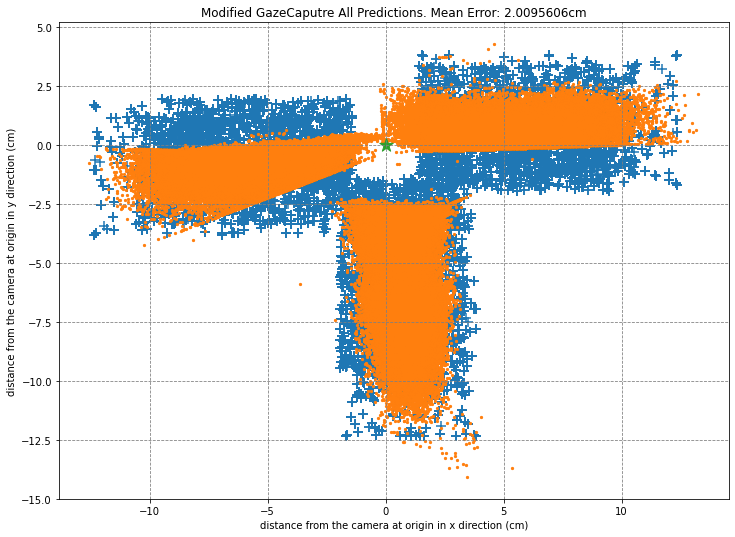

In [ ]:
import colorsys
import random

def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

c = get_colors(30)
random.shuffle(c)
def euc(a, b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))
    
plt.figure(figsize=(12,12))
plt.title('Modified GazeCaputre All Predictions. Mean Error: '+str(dist.mean())+"cm")
plt.grid(color='gray', linestyle='dashed')

plt.scatter(gt[:,0], gt[:,1],  marker='+', s=100)
plt.scatter(preds[:,0], preds[:,1], s=5)
plt.scatter(0, 0, marker='*', s=200)



plt.xlabel('distance from the camera at origin in x direction (cm)')
plt.ylabel('distance from the camera at origin in y direction (cm)')
plt.axis('scaled')
plt.savefig('GTFull')

## Test Participant Wise

In [18]:
all_files = glob(f+"/*.jpg")
all_files = [i[:-10] for i in all_files]
files = np.unique(all_files)
print('Found ', len(all_files), ' images from ', len(files), ' subjects.')

fnames = []
nums = []
for i in tqdm(files):
    fnames.append(i)
    nums.append(len(glob(i+"*.jpg")))
fnames = np.array(fnames)
nums = np.array(nums)
ids = np.argsort(nums)
ids = ids[::-1]
fnames_sorted = fnames[ids]
nums_sorted = nums[ids]
files = fnames_sorted.copy()
nums_sorted[0], nums_sorted[-1], sum(nums_sorted)

Found  32  images from  1  subjects.


100%|██████████| 1/1 [00:00<00:00, 1621.93it/s]


(32, 32, 32)

In [19]:
total_test = {}

for idx in tqdm(range(len(files))):    
    preds, gt = [], []
    ctr = 1
    f = files[idx]
    test_dataset = gazetrack_dataset(f, phase='test')
    test_dataloader = DataLoader(test_dataset, batch_size=100, num_workers=10, pin_memory=False, shuffle=False,)

    for j in test_dataloader:
        leye, reye, kps, target = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda()

        with torch.no_grad():
            pred = model(leye, reye, kps)
        pred = pred.detach().cpu().numpy()
        preds.extend(pred)  

        gt.extend(target.detach().cpu().numpy())

    preds = np.array(preds)
    pts = np.unique(gt, axis=0)

    gt = np.array(gt)
    dist = euc(preds, gt)
    total_test[f] = [dist, gt, preds, pts]

  0%|          | 0/1 [00:00<?, ?it/s]

Num files for test = 32


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8

Text(0, 0.5, 'Mean Euclidean Distance')

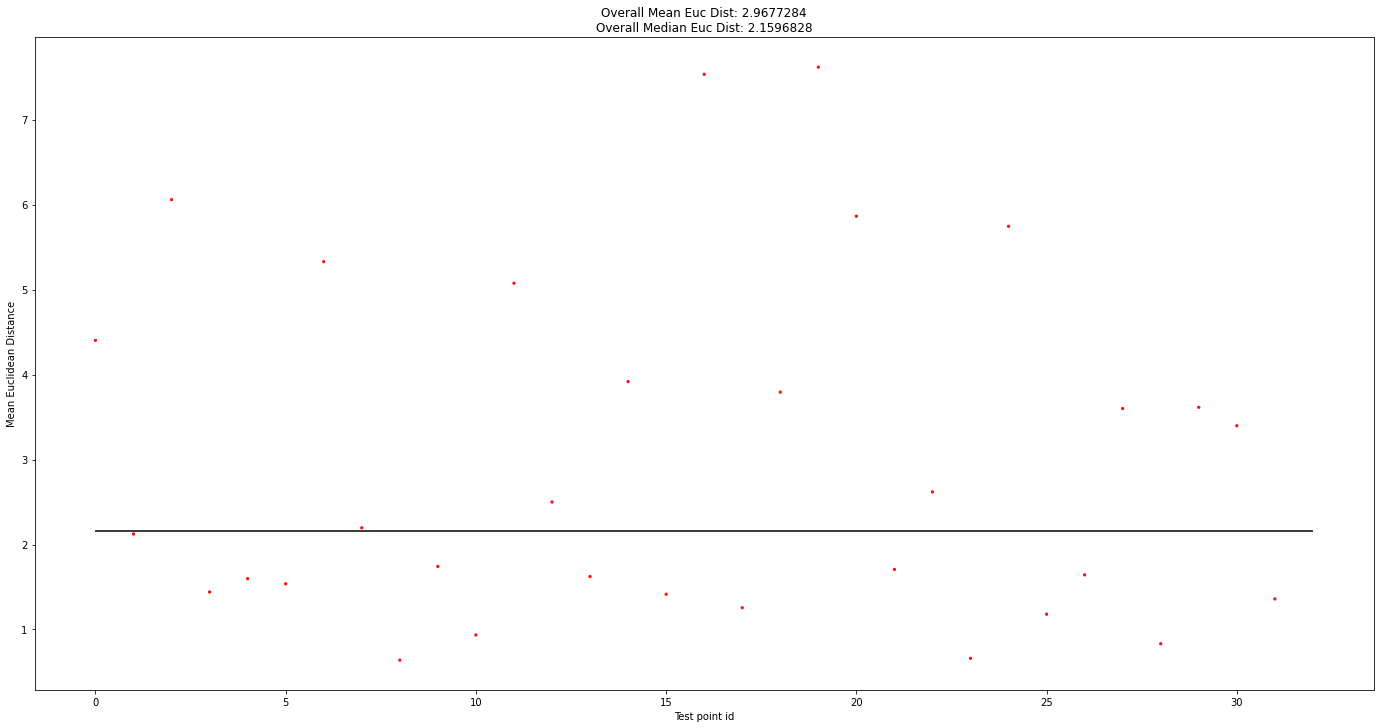

In [20]:
mean_errs = []
cols = []
c = get_colors(len(total_test))
random.shuffle(c)
for idx, i in enumerate(total_test):
    mean_errs.extend(total_test[i][0])
    cols.extend([c[idx] for j in range(len(total_test[i][0]))])
    
plt.figure(figsize=(24, 12))
plt.title("Overall Mean Euc Dist: "+str(np.mean(mean_errs)) + "\nOverall Median Euc Dist: "+str(np.median(mean_errs)))
plt.scatter([i for i in range(len(mean_errs))], mean_errs,c=cols, s=5)
plt.hlines(y=np.mean(mean_errs), xmin=0, xmax=len(mean_errs), color='white')
plt.hlines(y=np.median(mean_errs), xmin=0, xmax=len(mean_errs), color='black')
plt.xlabel('Test point id')
plt.ylabel('Mean Euclidean Distance')


## Random Test

device:  iPhone 6
id:  0
Num files:  32
Sample:


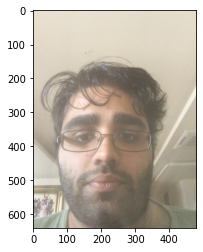

In [22]:
idx = 0
meta = json.load(open(glob(files[idx].replace('images', 'meta')+"*.json")[0]))
print("device: ", meta['device'])
print("id: ", idx)
print("Num files: ", len(glob(files[idx]+"*.jpg")))
print("Sample:")
plt.imshow(plt.imread(glob(files[idx]+"*.jpg")[0]))

Num files for test = 32
Mean Euclidean Distance:  2.9677284


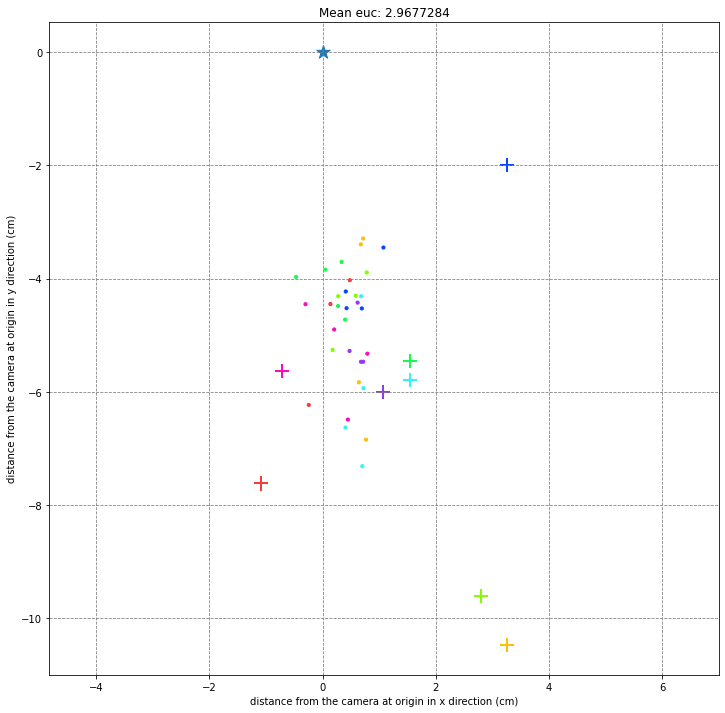

In [23]:
preds, gt = [], []
ctr = 1
f = files[idx]
fs = glob(f+"*.jpg")
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=256, num_workers=10, pin_memory=False, shuffle=False,)

preds, gt = [], []
for j in test_dataloader:
    leye, reye, kps, target = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda()

    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.detach().cpu().numpy()
    preds.extend(pred)  

    gt.extend(target.detach().cpu().numpy())

preds = np.array(preds)
pts = np.unique(gt, axis=0)

c = get_colors(len(pts))
random.shuffle(c)

gt = np.array(gt)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())
plot_pts(f, gt, preds, pts, c, "Mean euc: "+str(dist.mean()))